In [1]:
import sys
sys.path.append("..")
import tensorflow as tf
import numpy as np
import os
import pickle, importlib, keras, random, Engine, tqdm, copy, json, time, argparse
from keras import backend as K
import util.Generator as Generator
import model.PLANBERT as Transformer
import util.Datahelper as dh

sys.argv = ' '
parser = argparse.ArgumentParser()
parser.add_argument('-test', action="store_true", default=True)
parser.add_argument('-ckptname', dest='ckptname', default=None, required=False)

parser.add_argument('-nl', dest='num_layers', default=2, required=False)
parser.add_argument('-nhd', dest='num_hidden_dims', default=2**9, required=False)
parser.add_argument('-nh', dest='num_heads', default=8, required=False)

parser.add_argument('-i', dest='use_item_feat', default=True, required=False)
parser.add_argument('-u', dest='use_user_feat', default=True, required=False)

parser.add_argument(
    '-pt_sample_func', dest='pt_sample_func', default='(lambda x:x)', required=False)
parser.add_argument(
    '-pt_sample_param', dest='pt_sample_param', default='0.6 * tab_row', required=False)
parser.add_argument(
    '-pt_history_func', dest='pt_history_func', default='(lambda x:x)', required=False)
parser.add_argument(
    '-pt_history_param', dest='pt_history_param', default='0', required=False)

parser.add_argument(
    '-ft_sample_func', dest='ft_sample_func', default='np.random.randint', required=False)
parser.add_argument(
    '-ft_sample_param', dest='ft_sample_param', default='tab_row', required=False)
parser.add_argument(
    '-ft_history_func', dest='ft_history_func', default='np.random.randint', required=False)
parser.add_argument(
    '-ft_history_param', dest='ft_history_param', default='20', required=False)

parser.add_argument('-nonimprove_limit', dest='nonimprove_limit', default=10, required=False)
parser.add_argument('-seed', dest='seed', default=0, required=False, type=int)
args = parser.parse_args()
print(args)

Engine.set_random_seed(args.seed)

basic_config = {
    'cuda_num' : Engine.GPU_max_free_memory(),
    'course_file' : '../datasets/Amazon_data/Beauty/basket_dataset.pkl',
    'num_times' : 20,
    'num_items' : 10000, 
    'batch_size' : 32, 
    'feats' : [5]
}
    
save_name = 'checkpoint/PLANBERT'
print(basic_config)

os.environ['CUDA_VISIBLE_DEVICES'] = str(basic_config['cuda_num'])
session_config = tf.compat.v1.ConfigProto()
session_config.gpu_options.allow_growth=True
session = tf.compat.v1.Session(config=session_config)

with open(basic_config['course_file'], 'rb') as f:
    user_dict = pickle.load(f)
    print('Total Number of Users : ' + str(len(user_dict)))
    
all_keys = list(user_dict.keys())
all_keys.sort()
np.random.shuffle(all_keys)
#used_keys, _ = dh.list_partition(all_keys, 0.1, seed=0)

train_keys, tv_keys = dh.list_partition(all_keys, 0.7, seed=0)
test_keys, valid_keys = dh.list_partition(tv_keys, 0.5, seed=0)

Using TensorFlow backend.


Namespace(ckptname=None, ft_history_func='np.random.randint', ft_history_param='20', ft_sample_func='np.random.randint', ft_sample_param='tab_row', nonimprove_limit=10, num_heads=8, num_hidden_dims=512, num_layers=2, pt_history_func='(lambda x:x)', pt_history_param='0', pt_sample_func='(lambda x:x)', pt_sample_param='0.6 * tab_row', seed=0, test=True, use_item_feat=True, use_user_feat=True)
{'cuda_num': 5, 'course_file': '../datasets/Amazon_data/Beauty/basket_dataset.pkl', 'num_times': 20, 'num_items': 10000, 'batch_size': 32, 'feats': [5]}
Total Number of Users : 10000


In [2]:
model_config = {
    'name' : 'PLAN-BERT',
    'mask_future' : False,
    'num_times' : basic_config['num_times'], 
    'num_items' : 0,
    'base_feats' : [
        [True, basic_config['num_items'], 'ItemID'],
        [True, 1, 'PredictToken'],
        [True, basic_config['num_times'], 'AbsoluteDay'],
    ],
    # [whether the feature is used, the dimension of the feature, the name of feature]
    'feats' : [
        [args.use_item_feat, basic_config['feats'][0], 'Rating'],
    ],
    
    'embedding_dim' : args.num_hidden_dims,
    'num_layers' : args.num_layers,
    'num_heads' : args.num_heads,
    
    'transformer_dropout' : 0.3,
    'embedding_dropout' : 0.3,
    
    'l2_reg_penalty_weight' : 0,
    'confidence_penalty_weight' : 0.1,
    'lrate' : 1e-4}

model = Transformer.Transformer(model_config)
# Pretraining : Course-level Masking

if args.test:
    model.load_weights(save_name + '.h5')
else:
    train_generator_config = {
        'name' : None,
        'training' : True, 
        'sample_func' : args.pt_sample_func,
        'sample_param' : args.pt_sample_param,
        'history_func' : args.pt_history_func,
        'history_param' : args.pt_history_param,

        'batch_size' : basic_config['batch_size'],
        'shuffle' : True,
        'fixed_seed' : False}

    train_generator = Generator.TimeMultihotGenerator(
        user_dict, train_keys, basic_config, train_generator_config)
    valid_generator = Generator.TimeMultihotGenerator(
        user_dict, valid_keys, basic_config, train_generator_config)

    Engine.fit(
        model=model, 
        train_generator=train_generator, 
        valid_generator=valid_generator, 
        epoch_limit=500, 
        loss_nonimprove_limit=args.nonimprove_limit,
        batch_size=basic_config['batch_size'], 
        use_cosine_lr=True, 
        model_save_path=None)
    
        # Fine-tune
    train_generator_config = {
        'name' : None,
        'training' : True, 
        'sample_func' : args.ft_sample_func,
        'sample_param' : args.ft_sample_param,
        'history_func' : args.ft_history_func,
        'history_param' : args.ft_history_param,

        'batch_size' : basic_config['batch_size'],
        'shuffle' : True,
        'fixed_seed' : False}

    train_generator = Generator.TimeMultihotGenerator(
        user_dict, train_keys, basic_config, train_generator_config)
    valid_generator = Generator.TimeMultihotGenerator(
        user_dict, valid_keys, basic_config, train_generator_config)

    Engine.fit(
        model=model, 
        train_generator=train_generator, 
        valid_generator=valid_generator, 
        epoch_limit=500, 
        loss_nonimprove_limit=args.nonimprove_limit,
        batch_size=basic_config['batch_size'], 
        use_cosine_lr=True, 
        model_save_path=None)

    model.save_weights(save_name + '.h5')

{'name': 'PLAN-BERT', 'mask_future': False, 'num_times': 20, 'num_items': 0, 'base_feats': [[True, 10000, 'ItemID'], [True, 1, 'PredictToken'], [True, 20, 'AbsoluteDay']], 'feats': [[True, 5, 'Rating']], 'embedding_dim': 512, 'num_layers': 2, 'num_heads': 8, 'transformer_dropout': 0.3, 'embedding_dropout': 0.3, 'l2_reg_penalty_weight': 0, 'confidence_penalty_weight': 0.1, 'lrate': 0.0001}


In [ ]:
importlib.reload(Engine)
test_generator_config = {
    'training' : False, 
    'max_sampling' : 6,
    'mask_rate' : None,
    'historical' : None,
    'batch_size' : 16,
    'shuffle' : False,
    'fixed_seed' : True}

results_mat = {}
wishlist_mat = {}
for h in list(range(4)) + list(range(5, 16, 5)):
    results_mat[h] = {}
    wishlist_mat[h] = {}
    for r in list(range(6)):
        test_generator_config['sample_func'] = '(lambda x:x)'
        test_generator_config['sample_param'] = str(r)
        test_generator_config['history_func'] = '(lambda x:x)'
        test_generator_config['history_param'] = str(h)
        
        test_generator_config['name'] = 'H={1}_R={0}'.format(r, h)
        test_generator = Generator.TimeMultihotGenerator(
            user_dict, test_keys, basic_config, test_generator_config)
        
        print(test_generator.name)
        recall_mean, NDCG_mean = Engine.test(model, test_generator, pred_window=[h, basic_config['num_times']])
        results_mat[h][r] = [recall_mean, NDCG_mean]
        recall_mean, NDCG_mean = Engine.wishlist_test_onehot(model, test_generator, pred_window=[h, basic_config['num_times']])
        wishlist_mat[h][r] = [recall_mean, NDCG_mean]

np.save('checkpoint/BERTriu-time.npy', results_mat)
np.save('checkpoint/BERTriu-wishlist.npy', wishlist_mat)

In [7]:
model1 = keras.Model(inputs=model.input, outputs=model.get_layer('transformer_1_self_attention').get_output_at(0)[1])

test_generator_config = {
    'training' : False, 
    'max_sampling' : 6,
    'mask_rate' : None,
    'historical' : None,
    'batch_size' : 16,
    'shuffle' : False,
    'fixed_seed' : True}

length = [user_dict[iter].shape[0] for iter in train_keys]
max_id = np.argmax(length)

output = []
input_list = []
for h in range(20):
    # Pretraining : Course-level Masking
    test_generator_config['sample_func'] = '(lambda x:x)'
    test_generator_config['sample_param'] = str(20)
    test_generator_config['history_func'] = '(lambda x:x)'
    test_generator_config['history_param'] = str(h)
    test_generator_config['name'] = '4Y R={0}_H={1}'.format(test_generator_config['sample_param'], test_generator_config['history_param'])
    test_generator = Generator.TimeMultihotGenerator(
        user_dict, train_keys, basic_config, test_generator_config)

    input = test_generator.data_generation(train_keys[max_id])
    input = [iter[np.newaxis] for iter in input]
    
    input_list.append(input[0])
    
    output.append(model1.predict(input))
output = np.concatenate(output, axis=0)

[Text(0, 0, 'Day 0(h=1,r=0)'),
 Text(0, 1, 'Day 1(h=1,r=1)'),
 Text(0, 2, 'Day 2(h=1,r=0)'),
 Text(0, 3, 'Day 3(h=1,r=0)'),
 Text(0, 4, 'Day 4(h=1,r=0)'),
 Text(0, 5, 'Day 5(h=1,r=0)'),
 Text(0, 6, 'Day 6(h=1,r=0)'),
 Text(0, 7, 'Day 7(h=2,r=0)'),
 Text(0, 8, 'Day 8(h=1,r=0)'),
 Text(0, 9, 'Day 9(h=1,r=1)'),
 Text(0, 10, 'Day 10(h=1,r=0)'),
 Text(0, 11, 'Day 11(h=1,r=0)'),
 Text(0, 12, 'Day 12(h=1,r=1)'),
 Text(0, 13, 'Day 13(h=1,r=1)'),
 Text(0, 14, 'Day 14(h=1,r=0)'),
 Text(0, 15, 'Day 15(h=2,r=0)'),
 Text(0, 16, 'Day 16(h=1,r=0)'),
 Text(0, 17, 'Day 17(h=1,r=0)'),
 Text(0, 18, 'Day 18(h=1,r=1)'),
 Text(0, 19, 'Day 19(h=1,r=1)')]

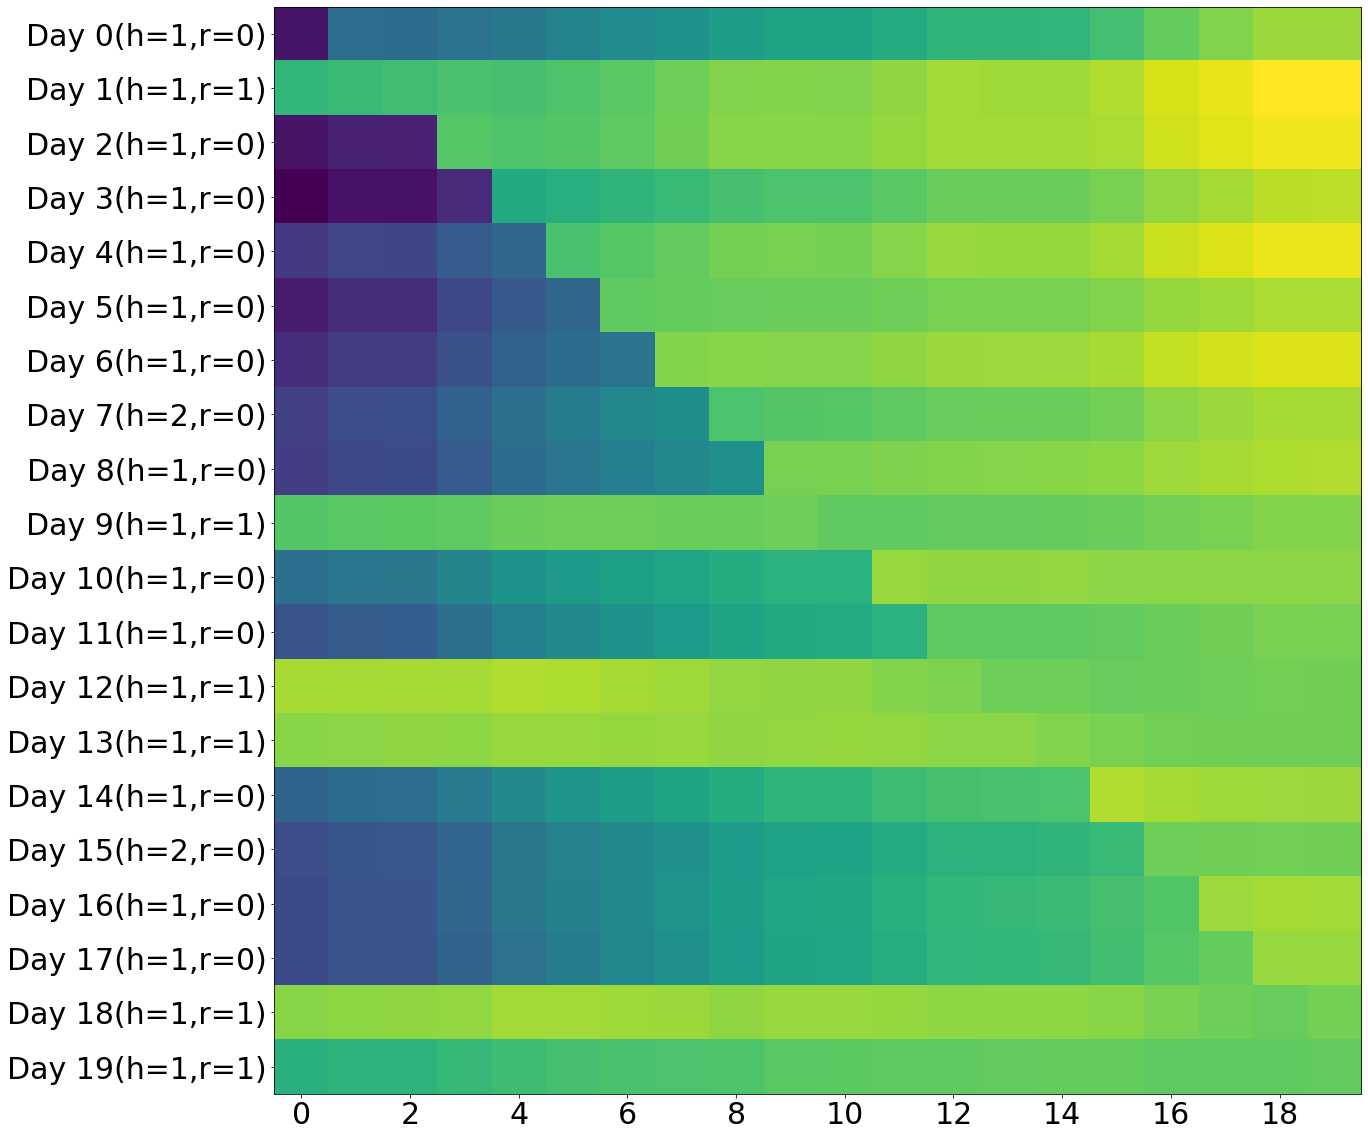

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

weights = output.sum(1).T
#weights = weights / np.sum(weights, 0)[np.newaxis,:]

fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111)
ax.imshow(weights)
ref_list = input_list[0].sum(-1)[0]
his_list = input_list[-1].sum(-1)[0]

y_pos = []
y_label = []
for iter in range(20):
    #if int(ref_list[iter]) > 0:
    if True:
        y_pos.append(iter)
        y_label.append('Day ' + str(iter) + '('+'h='+str(int(his_list[iter])) +',r='+str(int(ref_list[iter])) + ')')
    
ax.xaxis.set_ticks(np.arange(0, 20, 2))
ax.xaxis.set_ticklabels(np.arange(0, 20, 2), fontsize=30)

ax.yaxis.set_ticks(y_pos)
ax.yaxis.set_ticklabels(y_label, fontsize=30)